# Fingerprint Classification Using OpenCV!

## Imports
Here, we'll import all the packages we need for this project.

In [ ]:
# If not already installed
!pip install keras
!pip install scikit-learn
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
import keras

# OR
from tensorflow import keras

# Sequential model is very useful in Keras
from keras.models import Sequential, model_from_json, model_from_yaml

# Import different layers for defining our networks
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical

# Shuffle dataset
from sklearn.utils import shuffle

# Import numpy
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

# For reading paths
import os

# For reading BMP files
import cv2 as cv
from cv2 import xfeatures2d_SIFT

# Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset
We will extract the needed files for the dataset here that we can use for our machine learning algorithm.  We'll show what the files in the datasets look like, but actually load our data using the `numpy` library.

In [ ]:
# Root dataset path
dataset_path = os.path.join("drive", "MyDrive", "PTC", "dataset", "dataset_FVC2000_DB4_B", "dataset")

# Training, testing, and npy paths
train_path = os.path.join(dataset_path, "train_data")
real_path = os.path.join(dataset_path, "real_data")
np_path = os.path.join(dataset_path, "np_data")

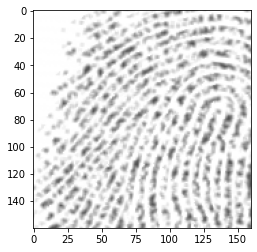

In [ ]:
def view_random_imgs(train_path):
  all_imgs = os.listdir(train_path)
  file_to_show = all_imgs[np.random.randint(low=0, high=len(all_imgs))]
  example_image_path = os.path.join(train_path, file_to_show)
  A = cv.imread(example_image_path)
  plt.imshow(A)
  return A

# This is our "analysis image"
A = view_random_imgs(train_path)

# View the Inverse Fingerprint

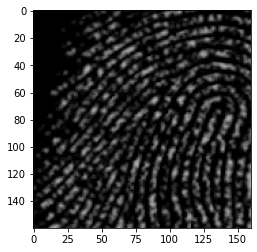

In [ ]:
# View the Inverse Fingerprint
plt.imshow(~A)  # The operator "~" inverts a binary image: True --> False, False --> True, 255 --> 0, 0 --> 255

# Detect Edges in Fingerprint

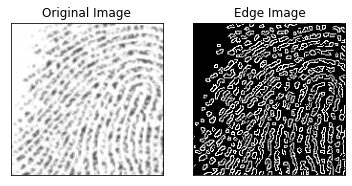

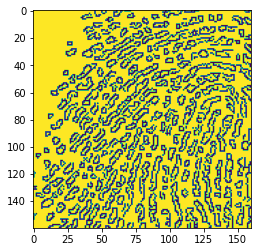

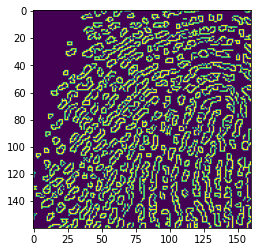

In [ ]:
# Link to tutorial: https://docs.opencv.org/master/da/d22/tutorial_py_canny.html

edges = cv.Canny(A,100,200)
plt.subplot(121),plt.imshow(A,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Let's plot the inverse edges too
plt.imshow(~edges)
plt.show()

# Let's plot the edges in a larger size
plt.imshow(edges)
plt.show()


# Blur the Fingerprint

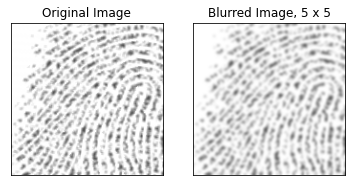

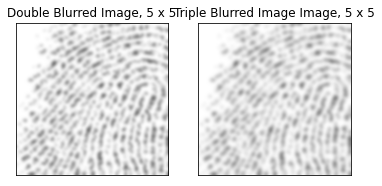

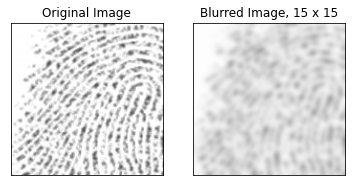

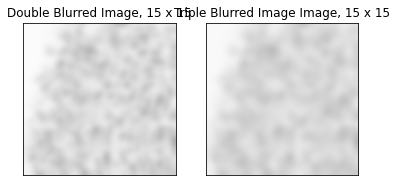

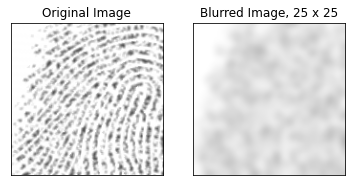

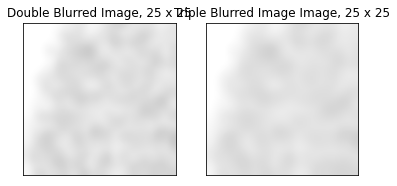

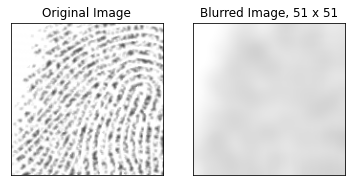

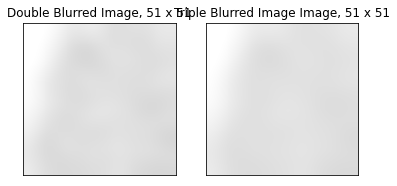

In [ ]:
def show_blurs(A, K):
  A_blur = cv.GaussianBlur(A,(K,K),0)
  A_blur2 = cv.GaussianBlur(A_blur,(K,K),0)
  A_blur3 = cv.GaussianBlur(A_blur2,(K,K),0)

  plt.subplot(121),plt.imshow(A,cmap = 'gray')
  plt.title('Original Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(A_blur,cmap = 'gray')
  plt.title('Blurred Image, {} x {}'.format(K, K)), plt.xticks([]), plt.yticks([])
  plt.show()

  # Blur it even more!
  plt.subplot(121),plt.imshow(A_blur2,cmap = 'gray')
  plt.title('Double Blurred Image, {} x {}'.format(K, K)), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(A_blur3,cmap = 'gray')
  plt.title('Triple Blurred Image Image, {} x {}'.format(K, K)), plt.xticks([]), plt.yticks([])
  plt.show()

# Now test it out!
show_blurs(A, 5)
show_blurs(A, 15)
show_blurs(A, 25)
show_blurs(A, 51)

# SIFT - Scale-Invariant Feature Transform
Now, we can try and do detection using SIFT!

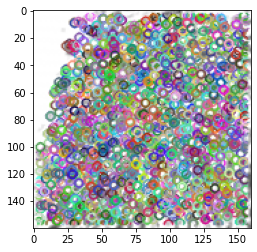

In [ ]:
#https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html

# Function to create SIFT
sift = xfeatures2d_SIFT.create()

# Run "keypoint detection on the image" - keypoints are "interesting points" on an image (these are regions with high contrast/structured surface orientation gradients)
kp = sift.detect(A,None)

# Draw and show the keypoints
img=cv.drawKeypoints(A,kp,A)
plt.imshow(img)

# Time to Run Feature Matching (Match A Fingerprint Template to An Image)

In [ ]:
#https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html

THRESHOLD_MATCHES = 200

def run_matching(n, class_train, class_query):
  # Load our images
  query_image_path = os.path.join(dataset_path, "train_data", '{}_{}.bmp'.format(str(class_query).zfill(5), str(n).zfill(2)))
  train_image_path = os.path.join(dataset_path, "real_data", '{}.bmp'.format(str(class_train).zfill(5)))

  img1 = cv.imread(query_image_path,cv.IMREAD_GRAYSCALE)          # queryImage - This is the fingerprint you check to see if it matches your fingerprint
  img2 = cv.imread(train_image_path,cv.IMREAD_GRAYSCALE)          # trainImage - This is the fingerprint you register

  # Initiate ORB detector
  orb = cv.ORB_create()

  # find the keypoints and descriptors with ORB
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)

  # create BFMatcher object
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

  # Match descriptors.
  matches = bf.match(des1,des2)

  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)

  print("NUMBER OF MATCHES: {}".format(len(matches)))
  if len(matches) > THRESHOLD_MATCHES: 
    print("WE HAVE A MATCH!  MATCH IS TO ID NUMBER: {}".format(class_train))

  # Draw first 10 matches.
  img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.imshow(img3)
  plt.title("Matches Between Query and Train Images, Class 0")
  plt.show()

NUMBER OF MATCHES: 208
WE HAVE A MATCH!  MATCH IS TO ID NUMBER: 0


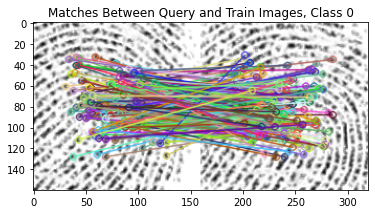

In [ ]:
# Run just a single match
run_matching(70, 0, 0)

NUMBER OF MATCHES: 192


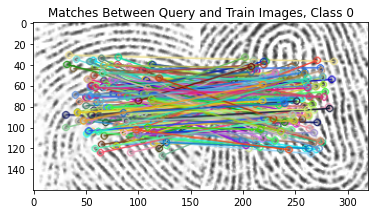

NUMBER OF MATCHES: 195


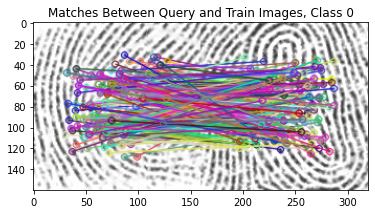

NUMBER OF MATCHES: 200


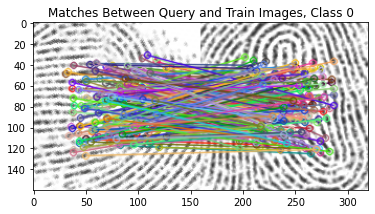

NUMBER OF MATCHES: 192


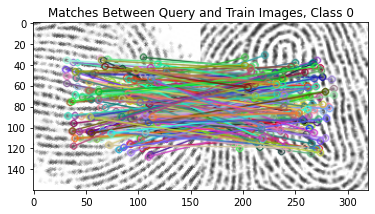

NUMBER OF MATCHES: 203
WE HAVE A MATCH!  MATCH IS TO ID NUMBER: 1


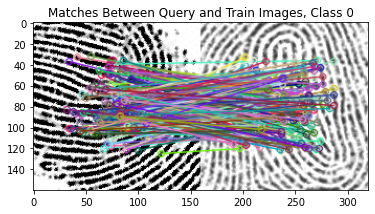

NUMBER OF MATCHES: 203
WE HAVE A MATCH!  MATCH IS TO ID NUMBER: 1


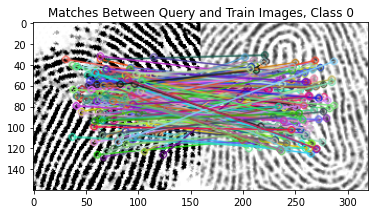

NUMBER OF MATCHES: 192


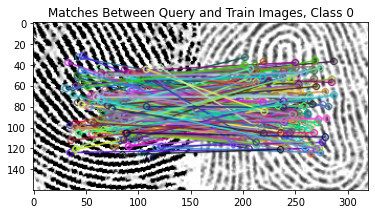

NUMBER OF MATCHES: 202
WE HAVE A MATCH!  MATCH IS TO ID NUMBER: 1


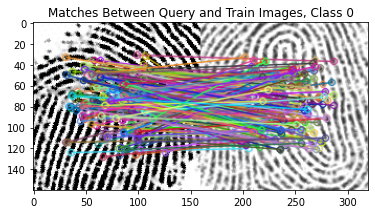

NUMBER OF MATCHES: 214
WE HAVE A MATCH!  MATCH IS TO ID NUMBER: 1


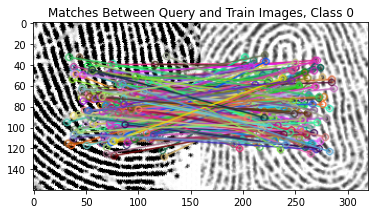

NUMBER OF MATCHES: 198


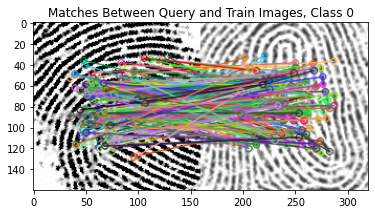

In [ ]:
# Running many matches at once
for i in range(10):
  run_matching(i, 1, 5)